In [1]:
############################## CNN - OVERFIT ##############################
#Note: Commented out code pieces are only needed in full dataset training 
import torch
import torch.optim as optim

import torchtext
from torchtext import data
import spacy

import argparse
import os


from models import *

import torch.nn as nn
from torch.autograd import Variable
import time

import matplotlib.pyplot as plt

#Hyperparameters 
learning_rate = 0.001
batch_size = 64
epochs = 100
seed = 0

torch.manual_seed(seed)

In [2]:
#Accuracy Function 
def accuracy(predictions, labels):
    totalCor = 0
    ind = 0
    
    for c in predictions:
        if (c.item()>0.5):
            r = 1.0
        else:
            r = 0.0
        
        if (r== labels[ind].item()):
            totalCor += 1
        ind += 1
    
    return (totalCor/len(labels))

Shape of Vocab: torch.Size([654, 100])
avg acc/epoch 0.5
[1,     1] avg loss/epoch: 0.718
avg acc/epoch 0.5
[2,     1] avg loss/epoch: 0.705
avg acc/epoch 0.5
[3,     1] avg loss/epoch: 0.695
avg acc/epoch 0.5
[4,     1] avg loss/epoch: 0.687
avg acc/epoch 0.5
[5,     1] avg loss/epoch: 0.682
avg acc/epoch 0.5
[6,     1] avg loss/epoch: 0.677
avg acc/epoch 0.5
[7,     1] avg loss/epoch: 0.674
avg acc/epoch 0.5
[8,     1] avg loss/epoch: 0.670
avg acc/epoch 0.5
[9,     1] avg loss/epoch: 0.667
avg acc/epoch 0.5
[10,     1] avg loss/epoch: 0.663
avg acc/epoch 0.5
[11,     1] avg loss/epoch: 0.658
avg acc/epoch 0.5
[12,     1] avg loss/epoch: 0.653
avg acc/epoch 0.5
[13,     1] avg loss/epoch: 0.647
avg acc/epoch 0.54
[14,     1] avg loss/epoch: 0.641
avg acc/epoch 0.62
[15,     1] avg loss/epoch: 0.635
avg acc/epoch 0.84
[16,     1] avg loss/epoch: 0.630
avg acc/epoch 0.92
[17,     1] avg loss/epoch: 0.625
avg acc/epoch 0.98
[18,     1] avg loss/epoch: 0.620
avg acc/epoch 1.0
[19,     1]

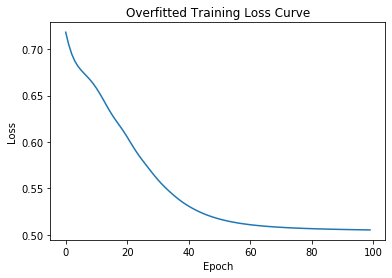

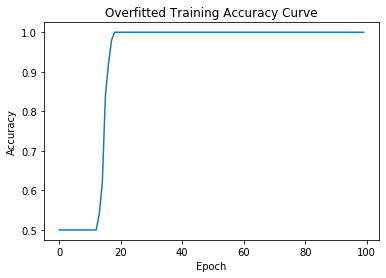

In [3]:
def main():
    # Instantiates 2 data.Field objects 
    TEXT = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
    LABELS = data.Field(sequential=False, use_vocab=False)

    # Load the overfit data
    train_data = data.TabularDataset(
            path='data/overfit.tsv', format='tsv',
            skip_header=True, fields=[('text', TEXT), ('label', LABELS)])

    # Create an object that can be enumerated (for training loop later)
    train_iter = data.BucketIterator(
      train_data, batch_size=batch_size,
    sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)
    
    # Vocab object contains the index/token for each unique word in the dataset (looks through all sentences in dataset)
    TEXT.build_vocab(train_data)

    # Loading GloVe Vector and Using Embedding Layer
    TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=100))
    vocab = TEXT.vocab

    print("Shape of Vocab:",TEXT.vocab.vectors.shape) #number of unique words 
    
    # Training the model ----------------------------------------------------------------
    # Reproducability 
    torch.manual_seed(seed)

    # Initiate model (different)
    model = CNN(100, vocab, 50, (2,4)) #(embedding_dim, vocab, n_filters, filter_sizes)
    
    # Define loss and optimzer functions 
    loss_fnc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

    # Store for plotting
    loss_list = []
    acc_list = []
    nepoch = []


    # TRAINING LOOP ----------------------------------------------------------------
    for e in range(epochs): 
        nepoch = nepoch + [e]

        batchloss_accum = 0.0
        batchacc_accum = 0.0
        #model.train() 

        for i, batch in enumerate(train_iter, 0): #len(train_iter) is the number of batches
            correct = 0 
            total = 0 

            # Zero parameter gradients
            optimizer.zero_grad()
            
            #Run model on inputs
            batch_input, batch_input_length = batch.text

            outputs = model(batch_input)
            #print(outputs.shape)
            #print(batch.label.float().shape)
            
            # Compute loss
            batchloss = loss_fnc(outputs, batch.label.float()) #(batch.label) (tensor of 64 1s and 0s)
            batchloss_accum = batchloss_accum + batchloss.item() #added values of loss for all batches
            #print('batchloss',batchloss)
            
            batchloss.backward()
            optimizer.step()
            
            # Compute accuracy 
            batchacc = accuracy(outputs,batch.label.float())
            batchacc_accum = batchacc_accum + batchacc
            #print("Batch accuracy",batchacc)
            
            if i == len(train_iter)-1: #Print training loss/accuracy every epoch 
                #model.eval()
                #vacc, vloss = evaluate(model,val_iter)
                
                print("avg acc/epoch", batchacc_accum/len(train_iter))
                print('[%d, %5d] avg loss/epoch: %.3f' % (e + 1, i + 1, batchloss_accum/len(train_iter)))
                
                #print("validation loss:", vloss)
                #print("validation acc:", vacc)

                loss_list = loss_list + [batchloss_accum/len(train_iter)]
                acc_list = acc_list + [batchacc_accum/len(train_iter)]
                
                #val_acc_list.append(vacc)   
                #val_loss_list.append(vloss)

                batchloss_accum = 0.0
                batchacc_accum = 0.0 
    #TRAIN LOSS 
    plt.plot(nepoch,loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss") 
    plt.title("Overfitted Training Loss Curve")
    plt.show() 

    #TRAIN ACC
    plt.plot(nepoch,acc_list)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy") 
    plt.title("Overfitted Training Accuracy Curve")
    plt.show()   


if __name__ == '__main__':
    main()

